In [1]:
from pathlib import Path
import pandas as pd

TODO:

1. [ ] finish graph:
    - [x] make colors in graph work
    - [x] separate into two graphs
    - [ ] get real data (1)
2. [ ] edit paper
3. [ ] talk with shrey
4. [ ] get effective LR from adam (?)
5. [ ] get hparams, run final (4hrs)

In [2]:
DIR = Path(".")

RUNS = [
    DIR / "data-tuning-2025-01-31" / "dampersweep",
    DIR / "data-tuning-ec2-2025-01-31" / "dampersweep",
    # DIR / "data-tuning2" / "dampersweep",
    # DIR / "data-tuning-ec2-2" / "dampersweep"
]

In [3]:
def cost(df):
    mu = df.iloc[-1]["model_updates"]
    final_loss = df.iloc[-1]["test_loss"]
    return final_loss + 0e-5*mu

_dfs = {f.name: pd.read_pickle(f) for runs in RUNS for f in runs.glob("*.pkl.zip")}
print(f"Reading/trimming {len(_dfs)} training runs...")
# _dfs = {k: df for k, df in _dfs.items() if df.epochs.max() >= 99}
print(" "*4 + f"after trimming epochs=99: {len(_dfs)}")

dfs = []
for fname, df in _dfs.items():
    df["fname"] = fname
    df["cost"] = cost(df)

    dampers = list(df.damper.unique())
    assert len(dampers) == 1
    damper = dampers[0]
    if damper == "pradadamp":
        damper = "radadamp"
    damplr = (df.initial_batch_size == df.max_batch_size).all()
    if damplr and "damp" in damper:
        damper = f"{damper}lr"

    assert len(set(df.initial_batch_size.unique())) == 1
    # if df.initial_batch_size.iloc[0] != 64:
    #     print(f"Skipping small ibs for {damper}")
    #     continue

    df["damper"] = damper
    df["final_score"] = df["test_loss"].iloc[-1]
    dfs.append(df)

print("Total models:", len(dfs))
df = pd.concat(dfs)
N = max(len(df) for df in dfs)
print(df.damper.value_counts() / N)
print(df.epochs.max())
cols = [c for c in df.columns if c not in ["fname", "params", "epoch_time", "verbose", "no_cuda", "random_state", "init_seed", "dataset", "approx_loss", "test_freq"]]
df[cols].sample(n=5)


Reading/trimming 387 training runs...
    after trimming epochs=99: 387
Total models: 387
damper
adagrad       42.099010
adamw         39.445545
padadamplr    33.267327
radadamp      32.465347
radadamplr    31.118812
padadamp      16.445545
geodamplr     15.673267
geodamp       14.554455
Name: count, dtype: float64
100.97213548332054


,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,lr,damper,rho,dwell,...,opt_param_momentum,opt_param_dampening,opt_param_nesterov,norm2_hist,loss_hist,norm2,loss,opt_param_betas,opt_param_amsgrad,opt_param_capturable
21,16,4096,0.01,3.720234,19,21.001075,0.000057,geodamp,0.990000,1.000000,...,0.989414,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,128,128,0.01,2.471403,18,15.004863,0.000066,geodamplr,0.990000,1.000000,...,0.998912,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,16,16,0.01,2.340820,15,19.000973,0.000019,geodamplr,0.990000,1.000000,...,0.980081,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,64,64,0.01,4.256971,12,3.000973,0.000045,geodamplr,0.990000,1.000000,...,0.979975,0.0,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,64,64,0.01,5.000000,20,92.029827,0.000049,radadamplr,0.793023,1661.014097,...,0.664192,0.0,True,"[13910.6787109375, 19301.125, 18814.29296875, ...","[8.421846389770508, 7.129207611083984, 9.06051...",36992.344398,9.962694,NaN,NaN,NaN


In [4]:
import numpy as np

best_runs = []
print(df.damper.unique())
dampers = [
    "geodamp",
    "geodamplr",
    "padadamp",
    "padadamplr",
    "radadamp",
    "radadamplr",
    "adamw",
    "adagrad",
]
assert set(dampers) == set(df.damper.unique())
for damper in dampers:
    show = df[df.damper == damper]
    scores = show.pivot_table(
        values="cost",
        aggfunc="min",
        index="fname",
        columns="damper",
    )
    idx = scores[damper].argmin()
    best_row = scores.iloc[idx]
    assert np.allclose(best_row.item(), scores.min())
    fname = best_row.name
    best_runs.append(fname)
best_runs

['adagrad' 'geodamp' 'padadamp' 'radadamp' 'radadamplr' 'padadamplr'
 'adamw' 'geodamplr']


['dam=geodamp-dam=17-dam=4.261973e+00-dwe=1-epo=100-gro=1.000000e-03-ini=16-lr=1.373842e-05-max=512-mom=9.907513e-01-nes=True-noi=False-red=mean-rho=9.900000e-01-wai=1-wei=2.075932e-06-201-3.pkl.zip',
 'dam=geodamplr-dam=17-dam=2.594838e+00-dwe=1-epo=100-gro=1.000000e-03-ini=16-lr=1.385823e-05-max=128-mom=9.920714e-01-nes=True-noi=False-red=mean-rho=9.900000e-01-wai=1-wei=4.318713e-06-201-1.pkl.zip',
 'dam=padadamp-dam=20-dam=5-dwe=8.189109e+01-epo=100-gro=1.374618e-03-ini=16-lr=4.610477e-05-max=8192-mom=5.190337e-01-nes=True-noi=False-red=mean-rho=9.900000e-01-wai=7.288363e+00-wei=2.490370e-06-201-0.pkl.zip',
 'dam=padadamplr-dam=20-dam=5-dwe=9.461080e+03-epo=100-gro=1.030792e-03-ini=32-lr=5.335091e-05-max=512-mom=8.745235e-01-nes=True-noi=False-red=mean-rho=9.900000e-01-wai=1.511339e+01-wei=1.235431e-06-201-2.pkl.zip',
 'dam=radadamp-dam=20-dam=5-dwe=4.754993e+02-epo=100-gro=1.000000e-03-ini=32-lr=1.089472e-04-max=128-mom=8.228173e-01-nes=True-noi=False-red=min-rho=8.999684e-01-wai=6

In [5]:
def clean(x):
    if isinstance(x, (np.bool_, np.float32, np.float64, np.int32, np.int64)):
        return x.item()
    if isinstance(x, dict):
        return {k: clean(v) for k, v in x.items()}
    return x
def get_params(df, damper):
    base = ["lr", "initial_batch_size", "weight_decay", "momentum", "nesterov"]
    more = []
    if "geodamp" in damper:
        more = ["dampingdelay", "dampingfactor", "dwell", "wait"]
    elif "padadamp" in damper:
        more = ["growth_rate", "dwell"]
    elif "radadamp" in damper:
        more = ["reduction", "rho", "dwell"]
    keys = base + more
    assert all(len(set(df[k].unique())) == 1 for k in keys)
    return {k: list(df[k].unique())[0] for k in keys}

best_params = dict()
for fname in best_runs:
    run = df[df.fname == fname]
    assert len(set(run.damper.unique())) == 1
    damper = run.iloc[0]["damper"]
    params = get_params(run, damper)
    best_params[damper] = params

from pprint import pprint
pprint(clean(best_params))

best_params = pd.DataFrame(best_params)
best_params

{'adagrad': {'initial_batch_size': 16,
             'lr': 0.000586232064449533,
             'momentum': 0.9943614698724406,
             'nesterov': True,
             'weight_decay': 7.508947154608012e-05},
 'adamw': {'initial_batch_size': 16,
           'lr': 0.00029542545461991147,
           'momentum': 0.9928515795145288,
           'nesterov': True,
           'weight_decay': 0.0001981062710677907},
 'geodamp': {'dampingdelay': 17,
             'dampingfactor': 4.261972703758296,
             'dwell': 1.0,
             'initial_batch_size': 16,
             'lr': 1.373842169473409e-05,
             'momentum': 0.9907513276282316,
             'nesterov': True,
             'wait': 100,
             'weight_decay': 2.075932174593111e-06},
 'geodamplr': {'dampingdelay': 17,
               'dampingfactor': 2.5948376580762544,
               'dwell': 1.0,
               'initial_batch_size': 16,
               'lr': 1.3858230239936032e-05,
               'momentum': 0.99207137619588

,geodamp,geodamplr,padadamp,padadamplr,radadamp,radadamplr,adamw,adagrad
lr,0.000014,0.000014,0.000046,0.000053,0.000109,0.00003,0.000295,0.000586
initial_batch_size,16,16,16,32,32,32,16,16
weight_decay,0.000002,0.000004,0.000002,0.000001,0.000001,0.000004,0.000198,0.000075
momentum,0.990751,0.992071,0.519034,0.874523,0.822817,0.941378,0.992852,0.994361
nesterov,True,True,True,True,True,True,True,True
dampingdelay,17,17,NaN,NaN,NaN,NaN,NaN,NaN
dampingfactor,4.261973,2.594838,NaN,NaN,NaN,NaN,NaN,NaN
dwell,1.0,1.0,81.891091,9461.079629,475.499283,4186.822969,NaN,NaN
wait,100,100,NaN,NaN,NaN,NaN,NaN,NaN
growth_rate,NaN,NaN,0.001375,0.001031,NaN,NaN,NaN,NaN


In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl

def prettify(axs):
    for i, ax in enumerate(axs):
        ax.grid(alpha=0.4)
        if i == 0:
            ax.legend_.remove()
        else:
            ax.legend(loc=(1.05, 0))
    
def plot_loss(show, damper, axs, debug=False, **kwargs):
    loss = "test_loss"
    show = show.copy()
    # show["test_loss"] = show["test_loss"] - show["train_loss"]
    for j, time in enumerate(["epochs", "model_updates"]):
        ax = show.plot(
            x=time,
            y=loss,
            ax=axs[j],
            **kwargs,
            label=damper if j == 1 else None,
        )
        if "updates" in time:
            ax.xaxis.set_major_formatter(lambda x, _: f"{int(x / 1e3)}K")
        if "epochs" in time:
            ax.set_xlim(0, 100)
        else:
            ax.set_xlim(0, 400e3)
        ax.set_ylim(0, 20)
        # ax.set_ylim(0, 10)
        ax.set_xlabel("Epochs" if time == "epochs" else "Model updates")
        ax.set_ylabel("Test loss" if j == 0 else "")
    return axs

def plot_bs(show, damper, axs, debug=False, **kwargs):
    for i, (time, damp) in enumerate([("epochs", "lr_"), ("epochs", "batch_size_")]):
        ax = show.plot(x=time, y=damp, ax=axs[i], label=damper, **kwargs)
        ax.set_yscale("log", base=2 if "batch" in damp else 10)
        ax.set_ylabel("Learning rate" if damp == "lr_" else "Batch size")
        ax.set_xlabel(time)
        ax.set_xlim(0, 101)
    return axs

In [7]:
colors = mpl.colormaps['tab10'].colors
styles = {
    "padadamp":   dict(color=colors[0], style="-"),
    "padadamplr": dict(color=colors[0], style="-."),
    "radadamp":   dict(color=colors[1], style="-"),
    "radadamplr": dict(color=colors[1], style="-."),
    "geodamp":    dict(color=colors[2], style="-"),
    "geodamplr":  dict(color=colors[2], style="-."),
    "adamw":      dict(color=colors[3], style="-."),
    "adagrad":    dict(color=colors[4], style="-."),
}

geodamp 100.24864772630322 [16]
geodamplr 100.0051190171487 [16]
padadamp 100.07072775360464 [16]
padadamplr 100.03242044194181 [32]
radadamp 100.03414384438187 [32]
radadamplr 100.03242044194181 [32]
adamw 100.0051190171487 [16]
adagrad 100.0051190171487 [16]


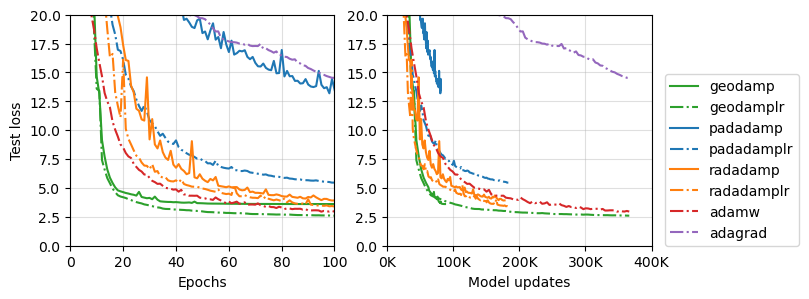

In [8]:
w = 3
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2.5 * w, 1.0 * w))
for run in best_runs:
    show = df[df.fname == run]
    assert len(show.fname.unique()) == 1
    damper = show.iloc[0]["damper"]
    # if "padadamp" in damper or damper in ["adagrad"]:
    #     continue
    print(damper, show.epochs.max(), show.initial_batch_size.unique())
    plot_loss(show, show.iloc[0]["damper"], axs, **styles[damper])
prettify(axs)
    # plot_loss(show, damper, axs[0], color=color, style=line)

geodamp 100.24864772630322 [16]
geodamplr 100.0051190171487 [16]
padadamp 100.07072775360464 [16]
padadamplr 100.03242044194181 [32]
radadamp 100.03414384438187 [32]
radadamplr 100.03242044194181 [32]
adamw 100.0051190171487 [16]
adagrad 100.0051190171487 [16]


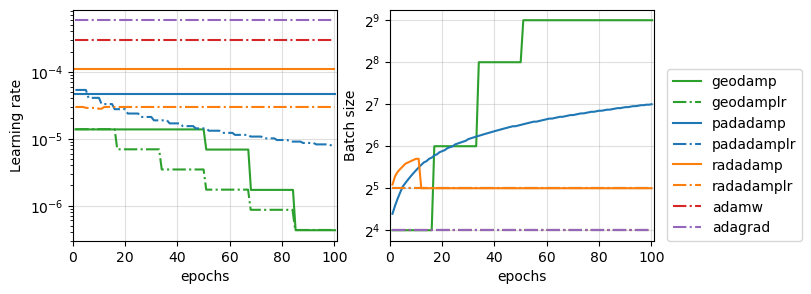

In [9]:
w = 3
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(2.5 * w, 1.0 * w))
for run in best_runs:
    show = df[df.fname == run]
    assert len(show.fname.unique()) == 1
    damper = show.iloc[0]["damper"]
    # if "padadamp" in damper or damper in ["adagrad"]:
    #     continue
    print(damper, show.epochs.max(), show.initial_batch_size.unique())
    plot_bs(show, show.iloc[0]["damper"], axs, **styles[damper])
prettify(axs)

In [284]:
    # plot_loss(show, damper, axs[0], color=color, style=line)

adamw [64]
radadamplr [32]
geodamp [512]
padadamplr [64]
padadamp [128]
adagrad [128]
radadamp [64]
geodamplr [32]


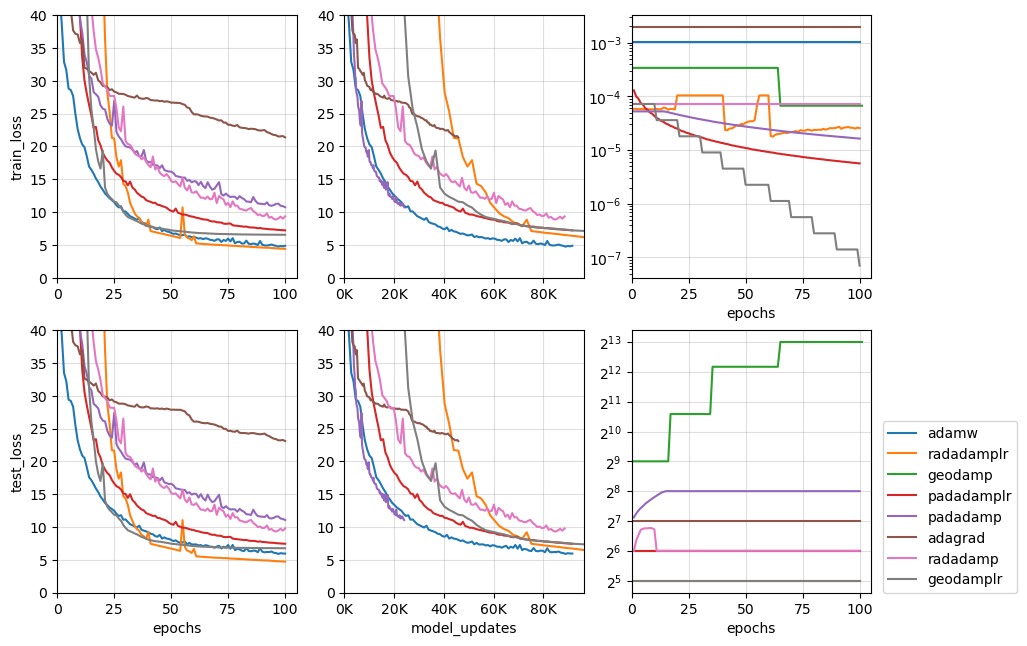

In [19]:
import matplotlib.pyplot as plt

def plot(show, damper, axs, debug=False):
    for i, loss in enumerate(["train_loss", "test_loss"]):
        for j, time in enumerate(["epochs", "model_updates"]):
            ax = show.plot(
                x=time,
                y=loss,
                ax=axs[i][j],
            )
            ax.set_ylabel(loss if j == 0 else "")
            ax.set_xlabel(time if i == 1 else "")
            if "updates" in time:
                ax.xaxis.set_major_formatter(lambda x, _: f"{int(x / 1e3)}K")

    for i, (time, damp) in enumerate([("epochs", "lr_"), ("epochs", "batch_size_")]):
        ax = show.plot(x=time, y=damp, ax=axs[i][2], label=damper)
        ax.set_yscale("log", base=2 if "batch" in damp else 10)
    
    for i, ax in enumerate(axs.flatten()):
        ax.grid(alpha=0.4)
        ax.set_xlim(0, None)
        if i in [0, 1, 3, 4]:
            ax.set_ylim(0, 40)
        if i != 5:
            ax.legend_.remove()
        else:
            ax.legend(loc=(1.05, 0))

        # if debug:
        #     if i in [0, 3]:
        #         ax.set_xlim(0, 40)
        #         ax.set_ylim(20, 120)

w = 3
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(3.5 * w, 2.5 * w))
for run in best_runs:
    show = df[df.fname == run]
    assert len(show.fname.unique()) == 1
    damper = show.iloc[0]["damper"]
    print(damper, show.initial_batch_size.unique())
    plot(show, damper, axs, debug=True)




TODO:
 
* breaking condition: `if epochs >= 25 and 60 < train_loss`
* trim smaller search space.


* padadamp:
    * dwell: 1 to 300
    * growth rate: 1e-3 to 1e2
    * lr: 1e-5 to 0.5e-3
    * max_batch_size? 2^7 to 2^11
    * momentum: 0.6 to 0.95
    * wait: <= 30
    * weight_decay: 1e-7 to 1e-5
* padadamplr:
    * dwell: 1 to 1000 (10_000?)
    * growth_rate: (1e-3) 1e-2 to 5e-1
    * lr: 1e-5 to 2e-3
    * max_batch_size: >= 2^9 is good.
    * momentum: >0.55
    * wait: 1 to 100
    * weigth_decay: 3e-7 to 1e-4
* radadamp:
    * dwell: 1 to 1000
    * ibs: 2^4 best. 2^8 very good. smooth ramp.
    * lr: <= 3e-4
    * mbs: 2^11 best. 2^8 to 2^12 very good.
    * momentum: lower is better. all within 0.5 to 0.65.
    * wait: 3 to 100.
    * weight_decay: 1e-7 to 1e-4.
    * reduction: mean or min, doesn't really matter.
    * rho: 0.3 to 0.9
* radadamplr:
    * dwell: 20 to 1000
    * ibs: 2^4 to 2^5
    * lr: 1e-5 to 3e-4
    * mbs: 2^8 to 2^13
    * momentum: 0.6 to 0.9
    * wait: 1 to 100
    * weight_decay: 1e-6 to 1e-5
    * reduction: doesn't matter. mean slightly better.
    * rho: 0.7 to 0.8
* geodamp:
    * (nothing converged)
    * lr > 1e-3 diverged. lr<1e-4 will work?
* geodamplr (only one convereged):
    * lr=0.7e-4
    * dampingfactor=2, dampingdelay=10 
    * (change dwell to dwell=1)
* adagrad:
    * lr <= 4e-3
    * ibs looks god
    * weight_decay looks good
    * momentum looks good
* adamw
    * lr 1e-3 to 3e-3
    * ibs in [2^4, 2^6]
    * high momentum >= 0.98
    * weight-decay: 1e-3 to 1e-1

In [22]:
cv_results[cv_results.param_damper == "radadamp"].pivot_table(
    index="param_reduction",
    values="mean_test_score",
    aggfunc="max",
)

NameError: name 'cv_results' is not defined

In [104]:
show

,epoch_time,initial_batch_size,max_batch_size,batch_growth_rate,dampingfactor,dampingdelay,epochs,verbose,lr,no_cuda,...,cost,opt_param_momentum,opt_param_dampening,opt_param_nesterov,norm2_hist,loss_hist,norm2,loss,opt_param_lr_decay,opt_param_initial_accumulator_value
0,1.738206e+09,64,256,0.01,5,20,0.000000,False,0.001026,False,...,131.854098,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.738206e+09,64,256,0.01,5,20,1.000324,False,0.001026,False,...,44.132120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.738206e+09,64,256,0.01,5,20,2.000648,False,0.001026,False,...,39.320619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.738206e+09,64,256,0.01,5,20,3.000973,False,0.001026,False,...,33.474219,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.738206e+09,64,256,0.01,5,20,4.001297,False,0.001026,False,...,32.215270,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,1.738211e+09,64,256,0.01,5,20,96.031124,False,0.001026,False,...,6.026220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
97,1.738211e+09,64,256,0.01,5,20,97.031448,False,0.001026,False,...,5.887566,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
98,1.738211e+09,64,256,0.01,5,20,98.031772,False,0.001026,False,...,6.007342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99,1.738211e+09,64,256,0.01,5,20,99.032096,False,0.001026,False,...,5.955266,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
